# A. Markovich, N. Puchkin
# Numerical experiments on synthetic data sets, described in the paper
# "Score-based change point detection via tracking the best of infinitely many experts"

In [17]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import normal as randn, multivariate_normal as randmn
import pandas as pd
from collections.abc import Iterable
from algorithms.score_based import *
from algorithms.fast_contrastive_change_point import compute_test_stat_ftal
from algorithms.kliep import compute_test_stat_kliep
from algorithms.m_statistic import compute_test_stat_mmd
from algorithms.cusum import compute_cusum
%load_ext autoreload
%autoreload 2

In [9]:
def reference_score(x):
    if isinstance(x, (int, float)):
        return np.array([-x]).reshape(-1, 1)
    return -x.reshape(-1, 1)

In [47]:
n=300
time = np.arange(1, n+1)

# colors for test statistic plots
c = {'Score-based + linear': 'r', 'Score-based + quadratic': 'b', 'Fast contrastive + hermite': 'g', 'KLIEP': 'm', 'M-statistic': 'c', 'CUSUM':'y'}

## Example 1: mean shift detection in a univariate sequence.

In [12]:
dim = 1
n = 300
tau = 150

sigma = 0.2
S_dict = {}

np.random.seed(1)
X1m = sigma * randn(size=n).reshape((n, dim, 1))
X1m[tau:] += 2*sigma


# score based linear+ref
model = ChangePointDetector(d_dim=dim, x_dim=dim, lambda_=10, alpha=3e-4, basis=PolyBasis(1, dim), reference_score=reference_score)
S, _ = model.run(X1m, eta=1)
S_dict['Score-based + linear'] = S

# score based quadratic
model = ChangePointDetector(d_dim=dim*2, x_dim=dim, lambda_=0.5, alpha=8e-5, basis=PolyBasis(2, dim))
S, _ = model.run(X1m, eta=0.2)
S_dict['Score-based + quadratic'] = S

X1m = X1m.flatten()
# FALCON + hermite, kliep, m-stat, cusum
S_hermite, _ = compute_test_stat_ftal(X1m, p=2, beta=0.01, design='hermite')
S_dict['Fast contrastive + hermite'] = S_hermite
S_kliep, _ = compute_test_stat_kliep(X1m, window_size=20, sigma=0.33)
S_dict['KLIEP'] = S_kliep
S_mmd, _ = compute_test_stat_mmd(X1m, window_size=20, sigma=1)
S_dict['M-statistic'] = S_mmd
S_cusum, _ = compute_cusum(X1m)
S_dict['CUSUM'] = S_cusum



In [13]:
st_dict1m = {}

# score based linear+ref
model = ChangePointDetector(d_dim=dim, x_dim = dim, lambda_=10, alpha=3e-4, basis=PolyBasis(1, dim), reference_score=reference_score, threshold=0.001)
_, st_lin = model.run(X1m.reshape((n, dim, 1)), 1)
st_dict1m['Score-based + linear'] = st_lin
# score based quadratic
model = ChangePointDetector(d_dim=dim*2, x_dim=dim, lambda_=0.5, alpha=8e-5, basis=PolyBasis(2, dim), threshold=10.71)
_, st_q = model.run(X1m.reshape((n, dim, 1)), 0.2)
st_dict1m['Score-based + quadratic'] = st_q


# FALCON + hermite, kliep, m-stat, cusum
_, st_ftal = compute_test_stat_ftal(X1m, p=2, beta=0.01, design='hermite', threshold=2.87)
st_dict1m['Fast contrastive + hermite'] = st_ftal
_, st_kliep = compute_test_stat_kliep(X1m, window_size=20, sigma=0.33, threshold=7.62)
st_dict1m['KLIEP'] = st_kliep
_, st_mmd = compute_test_stat_mmd(X1m, window_size=20, sigma=1, threshold=9.59)
st_dict1m['M-statistic'] = st_mmd
_, st_cusum = compute_cusum(X1m, threshold=0.908)
st_dict1m['CUSUM'] = st_cusum

In [14]:
st_dict1m

{'Score-based + linear': 156,
 'Score-based + quadratic': 155,
 'Fast contrastive + hermite': 156,
 'KLIEP': 159,
 'M-statistic': 161,
 'CUSUM': 154}

In [15]:
df1m = pd.DataFrame(S_dict)
df1m /= df1m.max()


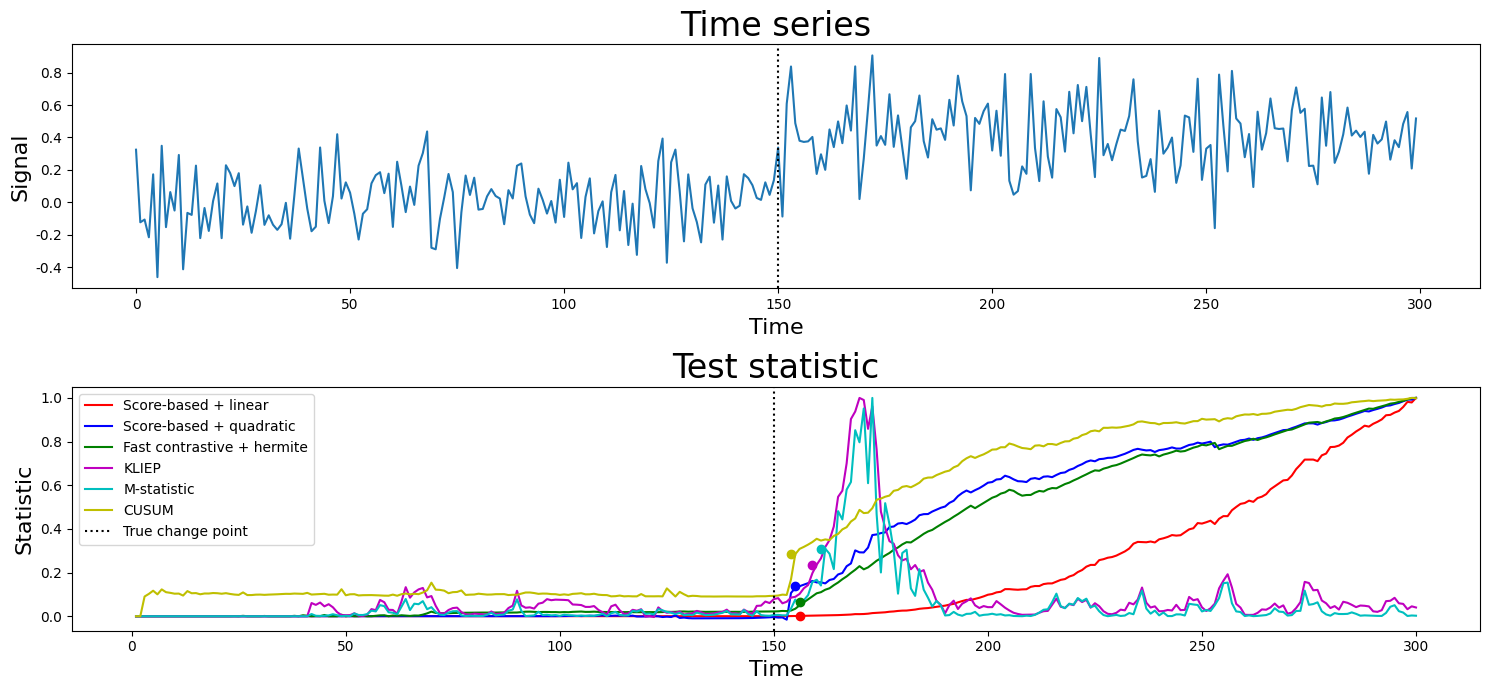

In [48]:
f, ax = plt.subplots(2, 1, figsize=(15, 7))

ax[0].set_title('Time series', fontsize=24)
ax[0].set_xlabel('Time', fontsize='16')
ax[0].set_ylabel('Signal', fontsize='16')
ax[0].plot(X1m)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))


ax[1].set_title('Test statistic', fontsize=24)
ax[1].set_xlabel('Time', fontsize='16')
ax[1].set_ylabel('Statistic', fontsize='16')
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

for col in df1m.columns:
    ax[1].plot(time, df1m[col], label=col, color=c[col])

for key in df1m.columns:
    ax[1].plot([st_dict1m[key]], [df1m.loc[st_dict1m[key], key]], 'o', color=c[key])


ax[0].axvline(tau, c='black', ls=':', label='True change point')
ax[1].axvline(tau, c='black', ls=':', label='True change point')

plt.tight_layout()
plt.legend()
plt.savefig('1d_mean_stats.png')
plt.show()

## Example 2: variance shift detection in a univariate sequence.

In [27]:
dim = 1
n = 300
tau = 150

sigma1 = 0.1
sigma2 = 0.3
S_dict = {}

np.random.seed(3)
X1v = randn(size=n).reshape((n, dim, 1))
X1v[:tau] *= sigma1
X1v[tau:] *= sigma2

# score based quadratic
model = ChangePointDetector(d_dim=dim*2, x_dim=dim, lambda_=1.5, alpha=1e-4, basis=PolyBasis(2, dim))
S, _ = model.run(X1v, eta=0.2)
S_dict['Score-based + quadratic'] = S

X1v = X1v.flatten()
# FALCON + hermite, kliep, m-stat
S_hermite, _ = compute_test_stat_ftal(X1v, p=3, beta=0.001, design='hermite')
S_dict['Fast contrastive + hermite'] = S_hermite
S_kliep, _ = compute_test_stat_kliep(X1v, window_size=20, sigma=0.33)
S_dict['KLIEP'] = S_kliep
S_mmd, _ = compute_test_stat_mmd(X1v, window_size=20, sigma=0.7)
S_dict['M-statistic'] = S_mmd



In [28]:
st_dict1v = {}


# score based quadratic
model = ChangePointDetector(d_dim=dim*2, x_dim=dim, lambda_=1.5, alpha=1e-4, basis=PolyBasis(2, dim), threshold=0)
_, st_q = model.run(X1v.reshape((n, dim, 1)), 0.2)
st_dict1v['Score-based + quadratic'] = st_q


# FALCON + hermite, kliep, m-stat
_, st_ftal = compute_test_stat_ftal(X1v, p=2, beta=0.01, design='hermite', threshold=1.44)
st_dict1v['Fast contrastive + hermite'] = st_ftal
_, st_kliep = compute_test_stat_kliep(X1v, window_size=20, sigma=0.33, threshold=4.15)
st_dict1v['KLIEP'] = st_kliep
_, st_mmd = compute_test_stat_mmd(X1v, window_size=20, sigma=1, threshold=5.55)
st_dict1v['M-statistic'] = st_mmd


In [29]:
st_dict1v

{'Score-based + quadratic': 153,
 'Fast contrastive + hermite': 177,
 'KLIEP': 167,
 'M-statistic': 214}

In [30]:
df1v = pd.DataFrame(S_dict)
df1v /= df1v.max()


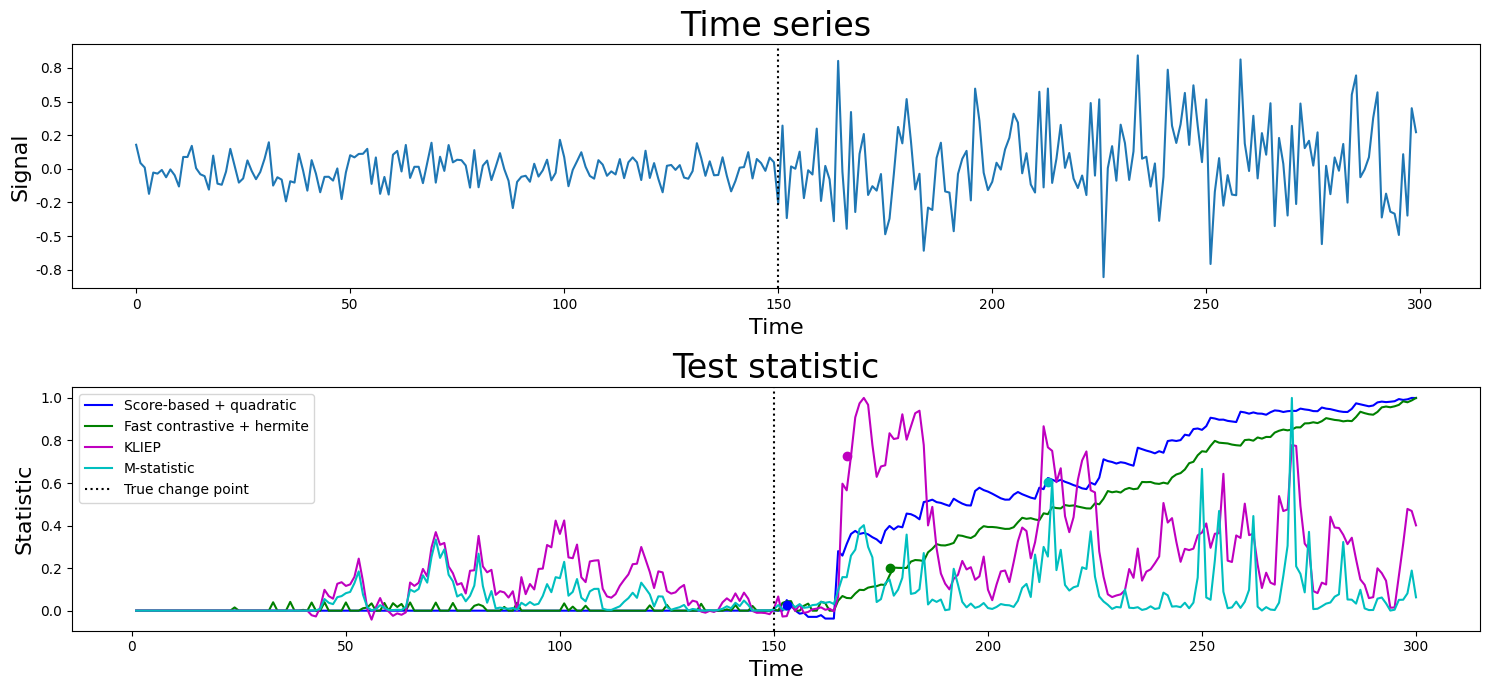

In [38]:
f, ax = plt.subplots(2, 1, figsize=(15, 7))
ax[0].set_title('Time series', fontsize=24)
ax[0].set_xlabel('Time', fontsize='16')
ax[0].set_ylabel('Signal', fontsize='16')
ax[0].plot(X1v)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax[1].set_title('Test statistic', fontsize=24)
ax[1].set_xlabel('Time', fontsize='16')
ax[1].set_ylabel('Statistic', fontsize='16')
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

for col in df1v.columns:
    ax[1].plot(time, df1v[col], label=col, color=c[col])

for key in df1v.columns:
    ax[1].plot([st_dict1v[key]], [df1v.loc[st_dict1v[key], key]], 'o', color=c[key])


ax[0].axvline(tau, c='black', ls=':', label='True change point')
ax[1].axvline(tau, c='black', ls=':', label='True change point')

plt.tight_layout()
plt.legend()
plt.savefig('1d_std_stats.png')
plt.show()

## Example 3: mean shift detection in a multivariate sequence.

In [33]:
dim = 3
mean = np.zeros(dim)
cov = np.eye(dim)
n=300
tau = 150
sigma = np.array([0.1, 0.2, 0.3])
S_dict = {}

np.random.seed(1)
X3m = randmn(mean, cov, size=n) * sigma[None, :]     
X3m[tau:] += 3*sigma[None, :]



# Score-based linear
model = ChangePointDetector(d_dim=dim, x_dim=dim, lambda_=10, alpha=1e-3, basis=PolyBasis(1, dim), reference_score=reference_score)
S, _ = model.run(X3m.reshape((n, dim, 1)), eta=10)
S_dict['Score-based + linear'] = S

# Score based quadratic
model = ChangePointDetector(d_dim=dim*2, x_dim=dim, lambda_=1.6, alpha=1e-7, basis=PolyBasis(2, dim))
S, _ = model.run(X3m.reshape((n, dim, 1)), eta=0.8)
S_dict['Score-based + quadratic'] = S

# FALCON + hermite, kliep, m-stat
S_hermite, _ = compute_test_stat_ftal(X3m, p=1, beta=1e-4, design='multivariate')
S_dict['Fast contrastive + hermite'] = S_hermite
S_kliep, _ = compute_test_stat_kliep(X3m, window_size=20, sigma=2)
S_dict['KLIEP'] = S_kliep
S_mmd, _ = compute_test_stat_mmd(X3m, window_size=20, sigma=4)
S_dict['M-statistic'] = S_mmd


            



In [34]:
st_dict3m = {}

# score based linear+ref
model = ChangePointDetector(d_dim=dim, x_dim = dim, lambda_=10, alpha=1e-3, basis=PolyBasis(1, dim), reference_score=reference_score, threshold=0.066)
_, st_lin = model.run(X3m.reshape((n, dim, 1)), eta=10)
st_dict3m['Score-based + linear'] = st_lin

# score based quadratic
model = ChangePointDetector(d_dim=dim*2, x_dim=dim, lambda_=1.6, alpha=1e-7, basis=PolyBasis(2, dim), threshold=29.49)
_, st_q = model.run(X3m.reshape((n, dim, 1)), 0.8)
st_dict3m['Score-based + quadratic'] = st_q

# FALCON + hermite, kliep, m-stat
_, st_ftal = compute_test_stat_ftal(X3m, p=1, beta=1e-4, design='multivariate', threshold=0)
st_dict3m['Fast contrastive + hermite'] = st_ftal
_, st_kliep = compute_test_stat_kliep(X3m, window_size=20, sigma=2, threshold=1.49)
st_dict3m['KLIEP'] = st_kliep
_, st_mmd = compute_test_stat_mmd(X3m, window_size=20, sigma=4, threshold=2.39)
st_dict3m['M-statistic'] = st_mmd


In [35]:
st_dict3m


{'Score-based + linear': 154,
 'Score-based + quadratic': 156,
 'Fast contrastive + hermite': 151,
 'KLIEP': 155,
 'M-statistic': 155}

In [36]:
df3m = pd.DataFrame(S_dict)
df3m /= df3m.max()


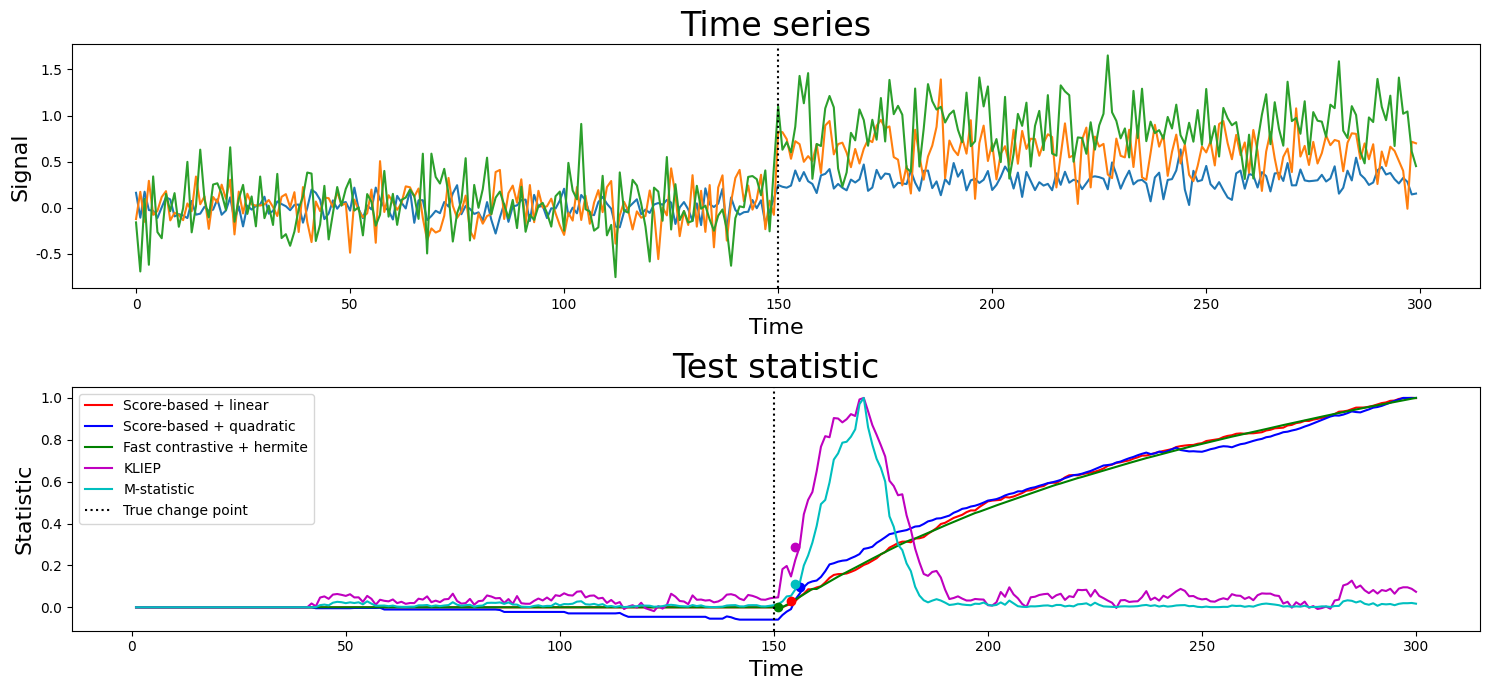

In [37]:
f, ax = plt.subplots(2, 1, figsize=(15, 7))
ax[0].set_title('Time series', fontsize=24)
ax[0].set_xlabel('Time', fontsize='16')
ax[0].set_ylabel('Signal', fontsize='16')
ax[0].plot(X3m)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))


ax[1].set_title('Test statistic', fontsize=24)
ax[1].set_xlabel('Time', fontsize='16')
ax[1].set_ylabel('Statistic', fontsize='16')
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

for col in df3m.columns:
    ax[1].plot(time, df3m[col], label=col, color=c[col])

for key in df3m.columns:
    ax[1].plot([st_dict3m[key]], [df3m.loc[st_dict3m[key], key]], 'o', color=c[key])


ax[0].axvline(tau, c='black', ls=':', label='True change point')
ax[1].axvline(tau, c='black', ls=':', label='True change point')

plt.tight_layout()
plt.legend()
plt.savefig('3d_mean_stats.png')
plt.show()

## Example 4: variance shift detection in a multivariate sequence. 

In [39]:

dim = 3
n = 300
tau = 150
runs = 10

sigma1 = np.array([0.1, 0.2, 0.3])
sigma2 = np.array([0.3, 0.6, 0.9])
mean = np.zeros(dim)
cov = np.eye(dim)

S_dict = {}

np.random.seed(1)
X3v = randmn(mean, cov, size=n)    
X3v[:tau] *= sigma1[None, :]       
X3v[tau:] *= sigma2[None, :]   

# Score based quadratic
model = ChangePointDetector(d_dim=dim*2, x_dim=dim, lambda_=1.5, alpha=1e-5, basis=PolyBasis(2, dim))
S, _ = model.run(X3v.reshape((n, dim, 1)), eta=0.3)
S_dict['Score-based + quadratic'] = S

# FALCON + hermite, kliep, m-stat
S_hermite, _ = compute_test_stat_ftal(X3v, p=1, beta=1e-4, design='multivariate')
S_dict['Fast contrastive + hermite'] = S_hermite
S_kliep, _ = compute_test_stat_kliep(X3v, window_size=20, sigma=2)
S_dict['KLIEP'] = S_kliep
S_mmd, _ = compute_test_stat_mmd(X3v, window_size=20, sigma=4)
S_dict['M-statistic'] = S_mmd


            



In [40]:
st_dict3v = {}

# score based quadratic
model = ChangePointDetector(d_dim=dim*2, x_dim=dim, lambda_=1.5, alpha=1e-5, basis=PolyBasis(2, dim), threshold=29.49)
_, st_q = model.run(X3v.reshape((n, dim, 1)), 0.3)
st_dict3v['Score-based + quadratic'] = st_q

# FALCON + hermite, kliep, m-stat
_, st_ftal = compute_test_stat_ftal(X3v, p=1, beta=1e-4, design='multivariate', threshold=0)
st_dict3v['Fast contrastive + hermite'] = st_ftal
_, st_kliep = compute_test_stat_kliep(X3v, window_size=20, sigma=2, threshold=1.49)
st_dict3v['KLIEP'] = st_kliep
_, st_mmd = compute_test_stat_mmd(X3v, window_size=20, sigma=4, threshold=2.39)
st_dict3v['M-statistic'] = st_mmd


In [41]:
st_dict3v

{'Score-based + quadratic': 153,
 'Fast contrastive + hermite': 152,
 'KLIEP': 202,
 'M-statistic': 171}

In [42]:
df3v = pd.DataFrame(S_dict)
df3v /= df3v.max()


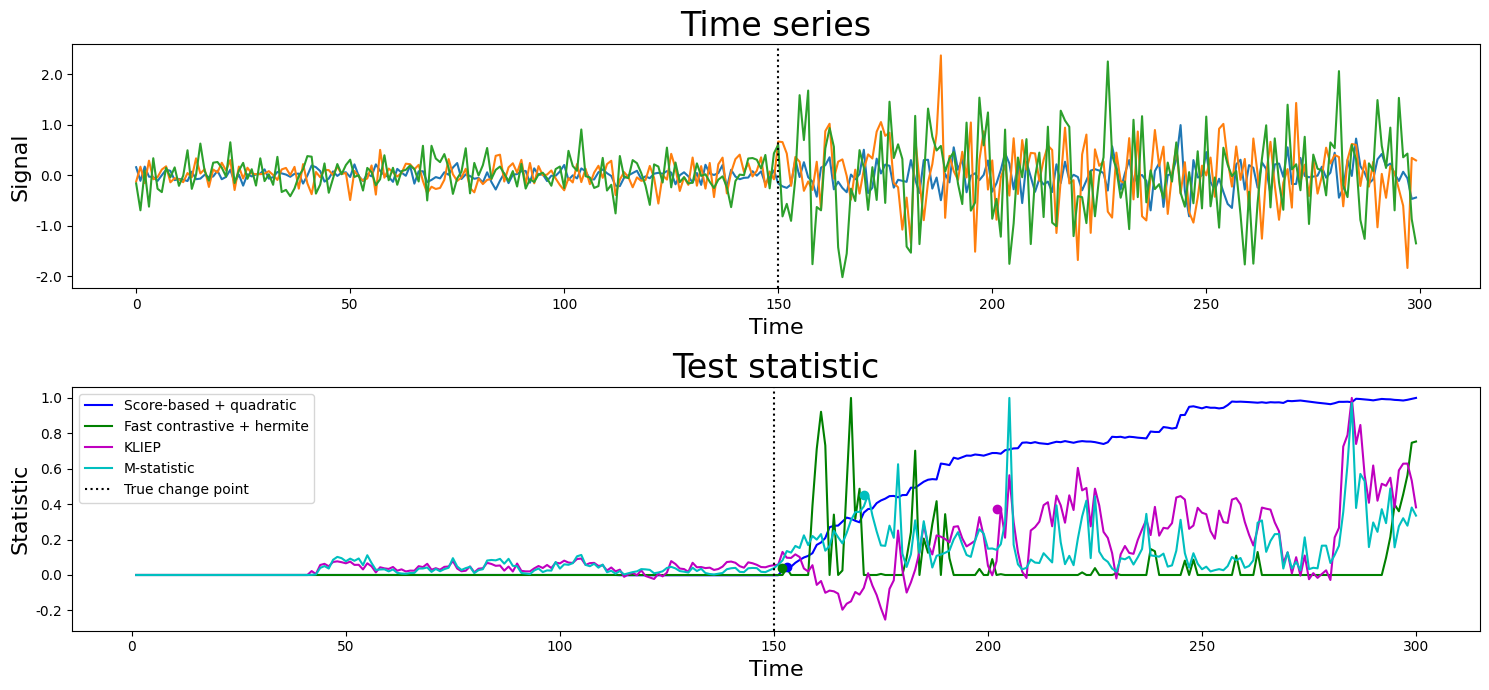

In [43]:
f, ax = plt.subplots(2, 1, figsize=(15, 7))

ax[0].set_title('Time series', fontsize=24)
ax[0].set_xlabel('Time', fontsize='16')
ax[0].set_ylabel('Signal', fontsize='16')
ax[0].plot(X3v)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))


ax[1].set_title('Test statistic', fontsize=24)
ax[1].set_xlabel('Time', fontsize='16')
ax[1].set_ylabel('Statistic', fontsize='16')
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

for col in df3v.columns:
    ax[1].plot(time, df3v[col], label=col, color=c[col])

for key in df3v.columns:
    ax[1].plot([st_dict3v[key]], [df3v.loc[st_dict3v[key], key]], 'o', color=c[key])


ax[0].axvline(tau, c='black', ls=':', label='True change point')
ax[1].axvline(tau, c='black', ls=':', label='True change point')

plt.tight_layout()
plt.legend()
plt.savefig('3d_std_stats.png')
plt.show()